# Using custom function of project
Import custom function and libraries

In [1]:
from libs.PretrainedModels import PretrainedModelsCreator, SqueezeNet_cc
from libs.utils import import_dataset, reverse_norm, init_model

from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
from torch import nn

## Import dataset

In [2]:
# default mean and std needed by pretrained models from pytorch
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

dst_v0 = import_dataset('dataset', 
    train_transform=transforms.Compose([
        transforms.Resize(256),
        transforms.RandomCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std) # default dev and std for pretrained models
    ]),
    test_transform=transforms.Compose([
        transforms.Resize(256), 
        transforms.CenterCrop(224), # crop centrale
        transforms.ToTensor(),
        transforms.Normalize(mean=mean, std=std)     # default dev and std for pretrained models
    ])
)

dst_v0.create_data_loader(batch_size=64, num_workers=2, drop_last=True)

### Visualize DataLoader

Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


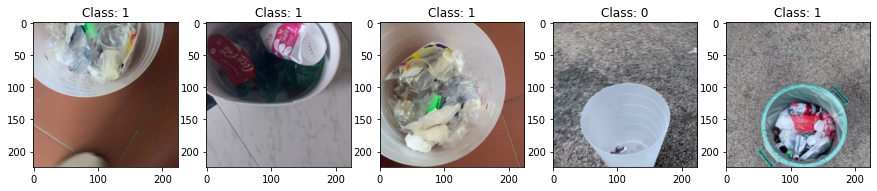

In [4]:
train_dataloader = dst_v0.training_loader

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")

plt.figure(figsize=(15,8))
for i in range(5):
    plt.subplot(2,5,i+1)
    plt.title("Class: %s" % train_labels[0].numpy())
    img = train_features[0].squeeze()
    label = train_labels[0]
    plt.imshow(reverse_norm(img.numpy().transpose(1, 2, 0)))
    train_features, train_labels = next(iter(train_dataloader))
plt.show()

### Default values for trainings

Define standard values for train the models. Needed only for test

In [3]:
num_epochs = 5
lr = 0.01
momentum = 0.9
criterion = nn.CrossEntropyLoss()

train_from_epoch = 0
save_each_iter = 1
resume_global_step_from = 0

Test that the functions work correctly and perform two training of 5 epoch on the SqueezeNet model: one pretrained and one from scratch

### Create SqueezeNet model and train

#### Train using pretrained model

In [4]:
squeezeNet_v0_fe = init_model(creator=SqueezeNet_cc(), model_name='SqueezeNet_v0_fe', feature_extract=True, use_pretrained=True)
squeezeNet_v0_fe.do_train(dataset=dst_v0, num_epochs=num_epochs, lr=lr, momentum=momentum, criterion=criterion, train_from_epoch=train_from_epoch, save_each_iter=save_each_iter, resume_global_step_from=resume_global_step_from)

Initializing: SqueezeNet_v0_fe
Feature extracting
	 classifier.1.weight
	 classifier.1.bias
INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2
Epoch 0/4
----------
validation Loss: 0.1357 Acc: 0.9466
Epoch 1/4
----------
validation Loss: 0.0831 Acc: 0.9649
Epoch 2/4
----------
validation Loss: 0.0688 Acc: 0.9733
Epoch 3/4
----------
validation Loss: 0.0594 Acc: 0.9794
Epoch 4/4
----------
validation Loss: 0.0609 Acc: 0.9771
Training complete in 38m 1s


SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

#### Train from scratch

In [7]:
squeezeNet_v0_scratch = init_model(creator=SqueezeNet_cc(), model_name='SqueezeNet_v0_scratch', feature_extract=False, use_pretrained=False)
model_trained = squeezeNet_v0_scratch.do_train(dataset=dst_v0, num_epochs=num_epochs, lr=lr, momentum=momentum, criterion=criterion, train_from_epoch=train_from_epoch, save_each_iter=save_each_iter, resume_global_step_from=resume_global_step_from)

Initializing: SqueezeNet_v0_scratch
Fine tuning
	 features.0.weight
	 features.0.bias
	 features.3.squeeze.weight
	 features.3.squeeze.bias
	 features.3.expand1x1.weight
	 features.3.expand1x1.bias
	 features.3.expand3x3.weight
	 features.3.expand3x3.bias
	 features.4.squeeze.weight
	 features.4.squeeze.bias
	 features.4.expand1x1.weight
	 features.4.expand1x1.bias
	 features.4.expand3x3.weight
	 features.4.expand3x3.bias
	 features.5.squeeze.weight
	 features.5.squeeze.bias
	 features.5.expand1x1.weight
	 features.5.expand1x1.bias
	 features.5.expand3x3.weight
	 features.5.expand3x3.bias
	 features.7.squeeze.weight
	 features.7.squeeze.bias
	 features.7.expand1x1.weight
	 features.7.expand1x1.bias
	 features.7.expand3x3.weight
	 features.7.expand3x3.bias
	 features.8.squeeze.weight
	 features.8.squeeze.bias
	 features.8.expand1x1.weight
	 features.8.expand1x1.bias
	 features.8.expand3x3.weight
	 features.8.expand3x3.bias
	 features.9.squeeze.weight
	 features.9.squeeze.bias
	 features